In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


1. 필요 라이브러리 및 모듈 import

In [2]:
#%% Import torch modules
import torch
from torch.utils.data import Dataset
from torch.cuda import empty_cache
import torch.nn as nn
## Utils
## Others
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
torch.manual_seed(0)
import matplotlib
# %matplotlib qt
font = {'size'   : 17}
matplotlib.rc('font', **font)

2. custom dataset load를 위한 함수 및 클래스 정의

In [3]:
#%% Define class and functions
def load_metal_dataset(metal_map, path):
    data = [None] * len(metal_map)
    label = [None] * len(metal_map)
    files = [f for f in listdir(path) if isfile(join(path, f))]
    for file in files:
        metal_name = file.split('.')[0]
        if metal_name not in metal_map.keys():
            # mapping에 없는 금속일 경우 건너뜀
            continue
        else:
            metal = pd.read_csv(path + file, header=None)
            label[metal_map[metal_name]] = np.ones(len(metal)).astype('uint8') * metal_map[metal_name]
            data[metal_map[metal_name]] = metal.values
    data = np.concatenate(data, axis=0)
    label = np.concatenate(label)
    return data, label

class MetalDataset(Dataset):
    def __init__(self, data, label, transform=None):
        self.data = data
        self.label = label
        self.transform = transform

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):
        data = np.reshape(self.data[index, :], (1, -1))
        if self.transform is not None:
            data = self.transform(data)
        label = self.label[index]
        label = torch.tensor(label).long()
        return data, label

    def get_items(self):
        data = np.reshape(self.data, (self.__len__(), 1, -1))
        if self.transform is not None:
            data = self.transform(data)
        label = self.label
        label = torch.tensor(label).long()
        return data, label

# Confirm device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'This module using {device} device...')

This module using cuda:0 device...


3. load할 metal을 metal_map을 통해 정하고 데이터 로드

In [4]:
#%% Load custom dataset
# load dataset
metal_map = {'al':0, 'cu':1, 'brass':2, 'fe':3, 'sus':4}

path = '/content/drive/My Drive/Colab Notebooks/'
train_data, train_label= load_metal_dataset(metal_map, path=path + 'train/')
test_data, test_label = load_metal_dataset(metal_map, path=path + 'test/')
wavelength = np.ravel(pd.read_csv(path + 'train/wavelength.csv', header=None).values)


# Dimensionality reduction
train_data = train_data[:,:10000]
test_data = test_data[:,:10000]

# train val split
val_ratio = 0.3
X_train, X_val, y_train, y_val = train_test_split(train_data, train_label, stratify = train_label, test_size = val_ratio)


4. 1d CNN을 위한 data loader과 transformation 정의

In [5]:
#%% Define dataset and loader
batch_size = 100

def transform_1d(data):  # Transform  -- 1d array to tensor type
    tensor = torch.from_numpy(data)
    tensor = tensor.type(torch.FloatTensor)
    return tensor

# make 1d image dataset
train_dataset = MetalDataset(data = X_train, label = y_train, transform = transform_1d)
val_dataset = MetalDataset(data = X_val, label = y_val, transform = transform_1d)
test_dataset = MetalDataset(data = test_data, label = test_label, transform = transform_1d)

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=(int)(batch_size * (1-val_ratio)), shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=(int)(batch_size * val_ratio), shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=100,shuffle=False)


6. CNN class 정의와 학습

In [6]:
#%% Build 1d CNN module
print('====== In this part 1d CNN is trained =====')

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.MaxPool1d(2, stride=2),
            nn.BatchNorm1d(num_features=1),
            nn.Conv1d(in_channels=1, out_channels=5, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(num_features=5),
            nn.ReLU(),
        )

        # Linear model (width*height*channel of the last feature map, Number of class)
        self.dropout = nn.Dropout(p=0.5)
        self.fc = nn.Linear(25000, num_classes)
        self.fc2 = nn.Softmax(dim=1)

        # Initialize
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):  # [ 100, 1, 32, 32] [B, C, H, W]
        out = self.layer1(x)  # conv1, batchorm, relu, maxpool
        # out = self.layer2(out)  # conv2, batchorm, relu, maxpool
        flatten = out.reshape(out.size(0), -1)  # Flatten
        flatten = self.dropout(flatten)
        score = self.fc(flatten)  # Score
        return score

# Define hyperparameters
num_epochs = 5
num_classes = len(metal_map)
learning_rate = 0.01

model = ConvNet().to(device)
print('Number of parameters: {}'.format(sum(p.numel() for p in model.parameters())))
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

train_losses, val_losses = [], []
for epoch in range(num_epochs):
    for i, (train_x, train_y) in enumerate(train_loader):
        # load validation
        val_x, val_y = next(iter(val_loader))
        train_x, train_y, val_x, val_y = train_x.to(device), train_y.to(device), val_x.to(device), val_y.to(device)

        # Forward pass
        output_train = model(train_x)
        output_val = model(val_x)

        train_loss = criterion(output_train, train_y)
        val_loss = criterion(output_val, val_y)
        train_losses.append(train_loss.detach())
        val_losses.append(val_loss.detach())

        # Backward and optimize
        optimizer.zero_grad()  # initialize optimizer
        train_loss.backward()
        optimizer.step()
        if i % 5 == 0:
            print(f'Epoch : {epoch + 1} \t train_loss : {train_loss} \t valid_loss : {val_loss}')

====== In this part 1d CNN is trained =====
Number of parameters: 125037
ConvNet(
  (layer1): Sequential(
    (0): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Conv1d(1, 5, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=25000, out_features=5, bias=True)
  (fc2): Softmax(dim=1)
)
Epoch : 1 	 train_loss : 1.6663262844085693 	 valid_loss : 1.7065327167510986
Epoch : 1 	 train_loss : 0.7304151058197021 	 valid_loss : 0.8258131146430969
Epoch : 1 	 train_loss : 1.0146279335021973 	 valid_loss : 0.571918249130249
Epoch : 1 	 train_loss : 0.040888454765081406 	 valid_loss : 0.03456127643585205
Epoch : 1 	 train_loss : 0.7528862357139587 	 valid_loss : 0.7171760201454163
Epoch : 2 	 train_loss : 

In [ ]:
model.parameters()

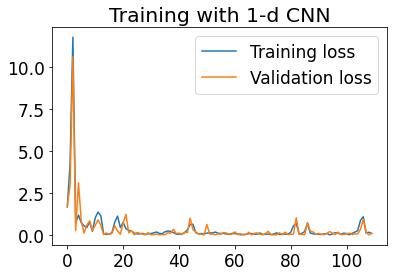

In [7]:
plt.figure()
plt.title('Training with 1-d CNN')
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()

7. Confusion matrix를 위한 함수 정의

In [10]:
import itertools
import seaborn as sns

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix'):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)
    cmap = sns.cubehelix_palette(light=1, as_cmap=True)
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')

8. Test dataset에 대해 평가 및 confusion matrix plot

Test Accuracy of the model on the test dataset: 61.05555555555556 %
Confusion matrix, without normalization


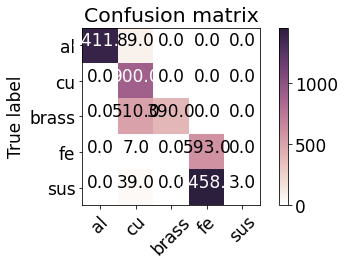

In [15]:
model.eval()
confusion_matrix = torch.zeros(num_classes, num_classes)
with torch.no_grad():
    correct = 0
    total = 0
    for test_x, test_y in test_loader:
        test_x, test_y = test_x.to(device), test_y.to(device)
        outputs = model(test_x)
        _, predicted = torch.max(outputs.data, 1)
        total += test_y.size(0)
        correct += (predicted == test_y).sum().item()
        for t, p in zip(test_y.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
    print('Test Accuracy of the model on the test dataset: {} %'.format(100 * correct / total))
confusion_matrix = confusion_matrix.cpu().detach().numpy()
plot_confusion_matrix(confusion_matrix, list(metal_map.keys()), False)

9. 2d CNN을 위한 data loader과 transformation 정의

In [17]:
#%% Build 2d CNN module
# 전처리나 hyperparameter는 동일하게 설정
print('====== In this part 2d CNN is trained =====')

def transform_2d(data):  # Transform  -- 2d array to tensor type
    data = np.reshape(data, (1, 100,100))
    tensor = torch.from_numpy(data)
    tensor = tensor.type(torch.FloatTensor)
    return tensor

batch_size = 100

# make 2d image dataset
train_dataset = MetalDataset(data = X_train, label = y_train, transform = transform_2d)
val_dataset = MetalDataset(data = X_val, label = y_val, transform = transform_2d)
test_dataset = MetalDataset(data = test_data, label = test_label, transform = transform_2d)

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=(int)(batch_size * val_ratio), shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=(int)(batch_size * (1-val_ratio)), shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=10,shuffle=False)

====== In this part 2d CNN is trained =====


10. CNN class 정의 및 학습

In [19]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.MaxPool2d(2, stride=2),
            nn.BatchNorm2d(num_features=1),
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=1),
            nn.ReLU(),
        )

        # Linear model (width*height*channel of the last feature map, Number of class)
        self.dropout = nn.Dropout(p=0.5)
        self.fc = nn.Linear(2500, num_classes)

        # Initialize
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):  # [ 100, 1, 32, 32] [B, C, H, W]
        out = self.layer1(x)  # conv1, batchorm, relu, maxpool
        flatten = out.reshape(out.size(0), -1)  # Flatten
        flatten = self.dropout(flatten)
        score = self.fc(flatten)  # Score
        return score


# Define hyperparameters
num_epochs = 5
num_classes = len(metal_map)
learning_rate = 0.01

model = ConvNet().to(device)
print('Number of parameters: {}'.format(sum(p.numel() for p in model.parameters())))
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses, val_losses = [], []
for epoch in range(num_epochs):
    for i, (train_x, train_y) in enumerate(train_loader):
        # load validation
        val_x, val_y = next(iter(val_loader))
        train_x, train_y, val_x, val_y = train_x.to(device), train_y.to(device), val_x.to(device), val_y.to(device)

        # Forward pass
        output_train = model(train_x)
        output_val = model(val_x)

        train_loss = criterion(output_train, train_y)
        val_loss = criterion(output_val, val_y)
        train_losses.append(train_loss.detach())
        val_losses.append(val_loss.detach())

        # Backward and optimize
        optimizer.zero_grad()  # initialize optimizer
        train_loss.backward()
        optimizer.step()
        if i % 20 == 0:
            print(f'Epoch : {epoch + 1} \t train_loss : {train_loss} \t valid_loss : {val_loss}')

Number of parameters: 12519
ConvNet(
  (layer1): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=2500, out_features=5, bias=True)
)
Epoch : 1 	 train_loss : 1.5801914930343628 	 valid_loss : 1.6073600053787231
Epoch : 1 	 train_loss : 0.11176502704620361 	 valid_loss : 0.13835053145885468
Epoch : 1 	 train_loss : 0.08892100304365158 	 valid_loss : 0.007831158116459846
Epoch : 2 	 train_loss : 0.018497582525014877 	 valid_loss : 0.10735882073640823
Epoch : 2 	 train_loss : 0.01848176307976246 	 valid_loss : 0.006819704547524452
Epoch : 2 	 train_loss : 0.006394243333488703 	 valid_loss : 0.01560367178171873

11. 성능 확인

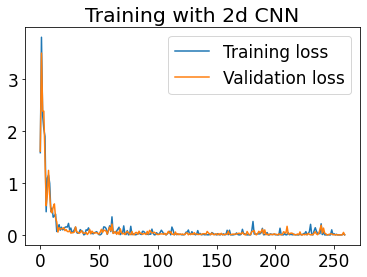

In [20]:
plt.title('Training with 2d CNN')
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()

12. 테스트 데이터셋에 대하여 성능 확인 및 confusion matrix

Test Accuracy of the model on the test dataset: 87.66666666666667 %
Confusion matrix, without normalization


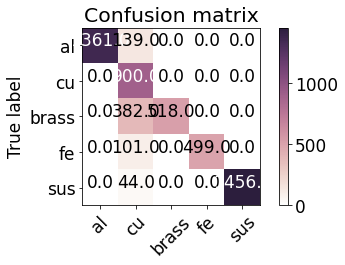

In [22]:
model.eval()
confusion_matrix = torch.zeros(num_classes, num_classes)
with torch.no_grad():
    correct = 0
    total = 0
    for test_x, test_y in test_loader:
        test_x, test_y = test_x.to(device), test_y.to(device)
        outputs = model(test_x)
        _, predicted = torch.max(outputs.data, 1)
        total += test_y.size(0)
        correct += (predicted == test_y).sum().item()
        for t, p in zip(test_y.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
    print('Test Accuracy of the model on the test dataset: {} %'.format(100 * correct / total))
  
confusion_matrix = confusion_matrix.cpu().detach().numpy()

plot_confusion_matrix(confusion_matrix, metal_map.keys(), False)